In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from scipy.stats import ttest_ind
from collections import defaultdict as ddict
from easydict import EasyDict as edict

%matplotlib inline

In [3]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT

In [4]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl, load_pkl

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.tensor
importlib.reload(utils.tensor)
from utils.tensor import decompose_three_way_orth, decompose_three_way_fix, sort_orthCPD

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

In [5]:
# gtvdn
import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_singular_vals, update_kp

import gtvdn.gtvdn_pre
importlib.reload(gtvdn.gtvdn_pre)
from gtvdn.gtvdn_pre import preprocess_MEG


### Some fns

In [6]:
def _get_eig_res(U, V, sing_val):
    """Based on singular recontructed matrix, obtain the eig result
    """
    assert U.shape[0] == V.shape[0]
    rec_mat = np.matmul(np.matmul(U, np.diag(sing_val)), V.T)
    eig_vals, eig_vecs = eig_sorted(rec_mat)
    return eig_vals, eig_vecs

In [7]:
_max_real_fn = lambda x: np.abs(np.array(x).real).max(axis=1).mean()
_max_imag_fn = lambda x: np.abs(np.array(x).imag).max(axis=1).mean()

## Load results

In [8]:
results = load_pkl(RES_ROOT/"CPD_results_detect_first.pkl")

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method1/../../mypkg/../results/CPD_results_detect_first.pkl


In [9]:
cpts_ADs = results.AD.cpts 
candidate_pts_ADs = results.AD.candidate_pts 
ndXmats_AD = results.AD.ndXmats 
nXmats_AD = results.AD.nXmats 
CPDresult_AD = results.AD.CPDres 

cpts_ctrls = results.ctrl.cpts 
candidate_pts_ctrls = results.ctrl.candidate_pts 
ndXmats_ctrl = results.ctrl.ndXmats 
nXmats_ctrl = results.ctrl.nXmats 
CPDresult_ctrl = results.ctrl.CPDres 


B1 = CPDresult_ctrl[0]
B2 = CPDresult_ctrl[1]

# update parameters 
paras.update(results.paras)

In [10]:
post_paras = edict()

##  Curves of singular values

In [11]:
B3_abs_AD = np.abs(CPDresult_AD[-1])
B3_abs_ctrl = np.abs(CPDresult_ctrl[-1])

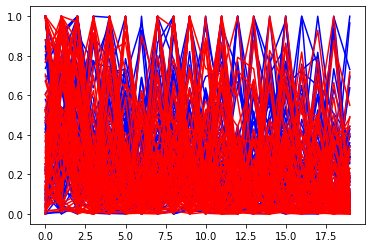

In [12]:
B3_abs_mm_AD = minmax_mat(B3_abs_AD, is_row=True)
B3_abs_mm_ctrl = minmax_mat(B3_abs_ctrl, is_row=True)
for ix in range(88):
    plt.plot(B3_abs_mm_AD[ix, :], "-b")
for ix in range(88):
    plt.plot(B3_abs_mm_ctrl[ix, :], "-r")

In [13]:
AD_mean = np.mean(B3_abs_mm_AD[:, :], axis=0)
AD_std = B3_abs_mm_AD.std(axis=0)
AD_low, AD_up = AD_mean - 1.96*AD_std/np.sqrt(88), AD_mean + 1.96*AD_std/np.sqrt(88)

ctrl_mean = np.mean(B3_abs_mm_ctrl[:, :], axis=0)
ctrl_std = B3_abs_mm_ctrl.std(axis=0)
ctrl_low, ctrl_up = ctrl_mean - 1.96*ctrl_std/np.sqrt(88), ctrl_mean + 1.96*ctrl_std/np.sqrt(88)

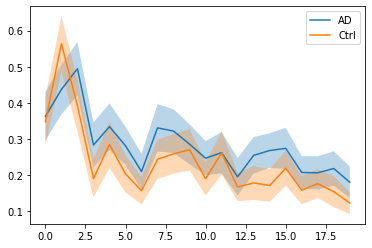

In [14]:
plt.plot(AD_mean, label="AD")
plt.plot(ctrl_mean, label="Ctrl")
plt.fill_between(np.arange(20), AD_low, AD_up, alpha=0.3)
plt.fill_between(np.arange(20), ctrl_low, ctrl_up, alpha=0.3)
plt.legend()

([], [])

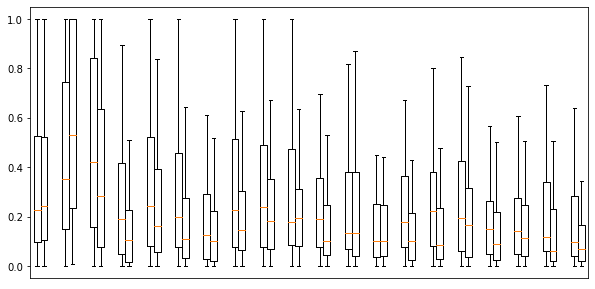

In [15]:
plt.figure(figsize=[10, 5])
plt.boxplot(B3_abs_mm_AD, positions=np.linspace(0, 39, 20), showfliers=False);
plt.boxplot(B3_abs_mm_ctrl, positions=np.linspace(0, 39, 20)+0.5, showfliers=False);
plt.xticks([])

## Select kappa

In [16]:
# sel kappa
cpts_ctrls_allkp = []
_, cur_r, n = nXmats_ctrl.shape
for kp in paras.kps:
    cpts_ctrl_allkp = np.array([update_kp(kp, ix.U0, n, cur_r, paras) for ix in cpts_ctrls])
    cpts_ctrls_allkp.append(cpts_ctrl_allkp)
    

cpts_ADs_allkp = []
_, cur_r, n = nXmats_AD.shape
for kp in paras.kps:
    cpts_AD_allkp = np.array([update_kp(kp, ix.U0, n, cur_r, paras) for ix in cpts_ADs])
    cpts_ADs_allkp.append(cpts_AD_allkp)

3.2132132132132134

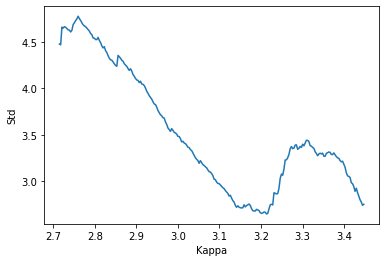

In [17]:
cpts_ctrls_allkp = np.array(cpts_ctrls_allkp)
cpts_ADs_allkp = np.array(cpts_ADs_allkp)
cpts_ctrl_std = cpts_ctrls_allkp.std(axis=1)
cpts_ctrl_mean = cpts_ctrls_allkp.mean(axis=1)

kps_keepidx_ctrl = np.bitwise_and(cpts_ctrls_allkp.mean(axis=1)>=3, cpts_ctrls_allkp.mean(axis=1)<=18)
#kps_keepidx_AD = np.bitwise_and(cpts_ADs_allkp.mean(axis=1)>=2, cpts_ADs_allkp.mean(axis=1)<=18)
#kps_keepidx_2grp = np.bitwise_and(kps_keepidx_AD, kps_keepidx_ctrl)


plt.plot(paras.kps[kps_keepidx_ctrl], cpts_ctrl_std[kps_keepidx_ctrl])
plt.xlabel("Kappa")
plt.ylabel("Std")


sel_kp = paras.kps[kps_keepidx_ctrl][np.argmin(cpts_ctrl_std[kps_keepidx_ctrl])]
post_paras.sel_kp = sel_kp
sel_kp

### change pts under selected kappa

In [18]:
cur_kp = sel_kp
_, cur_r, n = ndXmats_ctrl.shape
ncpts_ctrls_selected = np.array([update_kp(cur_kp, ix.U0, n, cur_r, paras) 
                                 for ix in cpts_ctrls])
cpts_ctrls_selected = [cur_cpts.chgMat[cur_ncpt-1, :cur_ncpt] 
                       for cur_ncpt, cur_cpts 
                       in zip(ncpts_ctrls_selected, cpts_ctrls)]


_, cur_r, n = ndXmats_AD.shape
ncpts_ADs_selected = np.array([update_kp(cur_kp, ix.U0, n, cur_r, paras) 
                               for ix 
                               in cpts_ADs])
cpts_ADs_selected = [cur_cpts.chgMat[cur_ncpt-1, :cur_ncpt] 
                     for cur_ncpt, cur_cpts 
                     in zip(ncpts_ADs_selected, cpts_ADs)]

In [19]:
dwells_ADs_selected = [np.diff(np.concatenate([[1], cpts_selected, [7200]])) 
                       for cpts_selected 
                       in cpts_ADs_selected]
dwells_ctrls_selected = [np.diff(np.concatenate([[1], cpts_selected, [7200]])) 
                         for cpts_selected 
                         in cpts_ctrls_selected]

Text(0.5, 1.0, 'AD (4.295) vs Ctrl (7.625)')

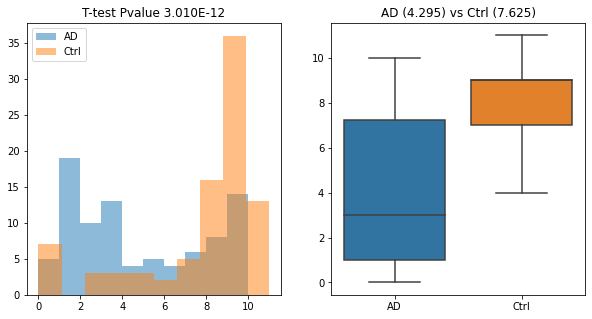

In [20]:
pval = ttest_ind(ncpts_ADs_selected, ncpts_ctrls_selected, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.hist(ncpts_ADs_selected, alpha=0.5, label="AD")
plt.hist(ncpts_ctrls_selected, alpha=0.5, label="Ctrl")
plt.title(f"T-test Pvalue {pval:.3E}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[ncpts_ADs_selected, ncpts_ctrls_selected], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({ncpts_ADs_selected.mean():.3f}) vs Ctrl ({ncpts_ctrls_selected.mean():.3f})")

##  Rank results

Text(0.5, 1.0, 'AD (5.761) vs Ctrl (5.170)')

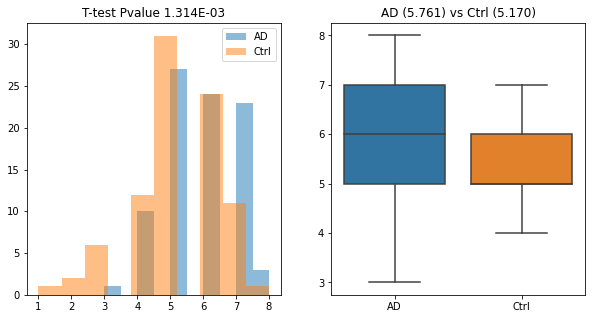

In [21]:
paras.cutoff=0.6
post_paras.rank_curoff = paras.cutoff 
#rank_ADs = np.sum(minmax_mat(np.abs(CPDresult_AD[2]), is_row=True) > paras.cutoff, axis=1)
#rank_ctrls = np.sum(minmax_mat(np.abs(CPDresult_ctrl[2]), is_row=True) > paras.cutoff, axis=1)
rank_ADs = np.array([len(cumsum_cutoff(np.abs(CPDresult_AD[2][ix]), paras.cutoff)) 
                     for ix 
                     in range(len(CPDresult_AD[2]))])
rank_ctrls = np.array([len(cumsum_cutoff(np.abs(CPDresult_ctrl[2][ix]), paras.cutoff)) 
                       for ix 
                       in range(len(CPDresult_ctrl[2]))])

pval = ttest_ind(rank_ADs, rank_ctrls, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.hist(rank_ADs, alpha=0.5, label="AD")
plt.hist(rank_ctrls, alpha=0.5, label="Ctrl")
plt.title(f"T-test Pvalue {pval:.3E}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[rank_ADs, rank_ctrls], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({rank_ADs.mean():.3f}) vs Ctrl ({rank_ctrls.mean():.3f})")

## Re-estimate the lambdas for each segment

In [22]:
singular_vals_ADs = []
singular_vals_ctrls = []

for ix in range(len(cpts_ADs_selected)):
    cur_singular_vals = est_singular_vals(cpts_ADs_selected[ix], ndXmats_AD[ix], nXmats_AD[ix])
    singular_vals_ADs.append(cur_singular_vals)
    
for ix in range(len(cpts_ctrls_selected)):
    cur_singular_vals = est_singular_vals(cpts_ctrls_selected[ix], ndXmats_ctrl[ix], nXmats_ctrl[ix])
    singular_vals_ctrls.append(cur_singular_vals)

Text(0.5, 1.0, 'AD (103.978) vs Ctrl (110.548)')

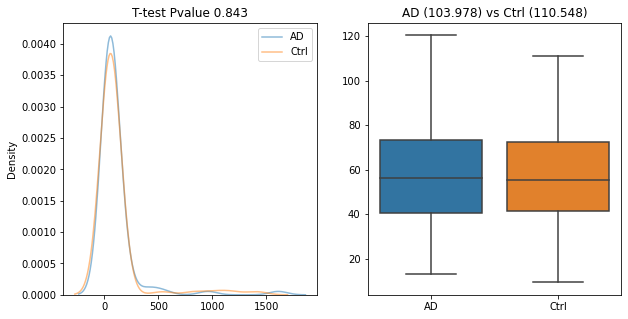

In [30]:
_max_mean_sig = lambda x: np.abs(x).max(axis=0).mean()
fs_AD = np.array([_max_mean_sig(x) for x in singular_vals_ADs])
fs_ctrl  = np.array([_max_mean_sig(x) for x in singular_vals_ctrls])

pval = ttest_ind(fs_AD, fs_ctrl, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
sns.kdeplot(fs_AD, alpha=0.5, label="AD")
sns.kdeplot(fs_ctrl, alpha=0.5, label="Ctrl")
plt.title(f"T-test Pvalue {pval:.3f}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[fs_AD, fs_ctrl], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({fs_AD.mean():.3f}) vs Ctrl ({fs_ctrl.mean():.3f})")

In [62]:
eig_vals_ADs = []
eig_vecs_ADs = []
for ix in range(len(singular_vals_ADs)):
    cur_sing_vals = singular_vals_ADs[ix]
    
    cur_eig_vals = []
    cur_eig_vecs = []
    for cur_sing_val in cur_sing_vals.T:
        cur_eig_val, cur_eig_vec = _get_eig_res(B1, B2, cur_sing_val)
        cur_eig_vals.append(cur_eig_val[:paras.r])
        cur_eig_vecs.append(cur_eig_vec[:, :paras.r])
    
    eig_vals_ADs.append(cur_eig_vals)
    eig_vecs_ADs.append(cur_eig_vecs)

In [64]:
eig_vals_ctrls = []
eig_vecs_ctrls = []
for ix in range(len(singular_vals_ctrls)):
    cur_sing_vals = singular_vals_ctrls[ix]
    
    cur_eig_vals = []
    cur_eig_vecs = []
    for cur_sing_val in cur_sing_vals.T:
        cur_eig_val, cur_eig_vec = _get_eig_res(B1, B2, cur_sing_val)
        cur_eig_vals.append(cur_eig_val[:paras.r])
        cur_eig_vecs.append(cur_eig_vec[:, :paras.r])
    
    eig_vals_ctrls.append(cur_eig_vals)
    eig_vecs_ctrls.append(cur_eig_vecs)

### Maximal abs real and imag parts

Text(0.5, 1.0, 'AD (14.001) vs Ctrl (12.822)')

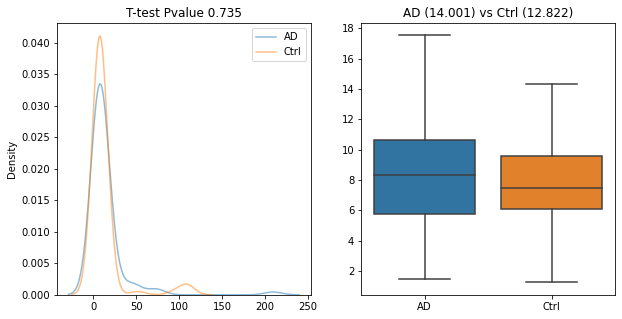

In [92]:
# real
abs_real_eig_max_mean_ctrls = np.array([_max_real_fn(cur_v) for cur_v in eig_vals_ctrls])
abs_real_eig_max_mean_ADs  = np.array([_max_real_fn(cur_v) for cur_v in eig_vals_ADs])

pval = ttest_ind(abs_real_eig_max_mean_ADs, abs_real_eig_max_mean_ctrls, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
sns.kdeplot(abs_real_eig_max_mean_ADs, alpha=0.5, label="AD")
sns.kdeplot(abs_real_eig_max_mean_ctrls, alpha=0.5, label="Ctrl")
plt.title(f"T-test Pvalue {pval:.3f}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[abs_real_eig_max_mean_ADs, abs_real_eig_max_mean_ctrls], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({abs_real_eig_max_mean_ADs.mean():.3f}) vs Ctrl ({abs_real_eig_max_mean_ctrls.mean():.3f})")

Text(0.5, 1.0, 'AD (10.067) vs Ctrl (9.706)')

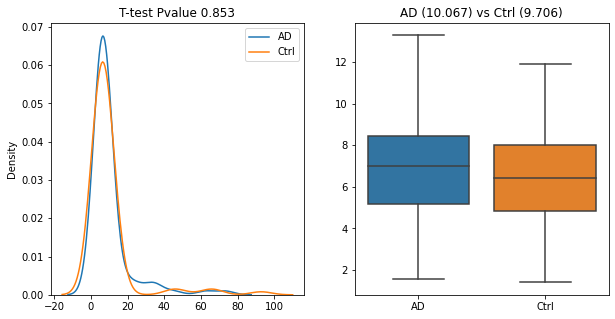

In [91]:
# imag
abs_imag_eig_max_mean_ctrls = np.array([_max_imag_fn(cur_v) for cur_v in eig_vals_ctrls])
abs_imag_eig_max_mean_ADs  = np.array([_max_imag_fn(cur_v) for cur_v in eig_vals_ADs])

pval = ttest_ind(abs_imag_eig_max_mean_ADs, abs_imag_eig_max_mean_ctrls, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
sns.kdeplot(abs_imag_eig_max_mean_ADs, alpha=1, label="AD")
sns.kdeplot(abs_imag_eig_max_mean_ctrls, alpha=1, label="Ctrl")
plt.title(f"T-test Pvalue {pval:.3f}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[abs_imag_eig_max_mean_ADs, abs_imag_eig_max_mean_ctrls], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({abs_imag_eig_max_mean_ADs.mean():.3f}) vs Ctrl ({abs_imag_eig_max_mean_ctrls.mean():.3f})")

## Save updated results

In [36]:
results.post_paras = post_paras

results.AD.singular_vals = singular_vals_ADs
results.AD.cpts_selected = cpts_ADs_selected
results.AD.dwells_selected = dwells_ADs_selected
results.AD.ranks = rank_ADs

results.ctrl.singular_vals = singular_vals_ctrls
results.ctrl.cpts_selected = cpts_ctrls_selected
results.ctrl.dwells_selected = dwells_ctrls_selected
results.ctrl.ranks = rank_ctrls

In [37]:
save_pkl(paras.res_dir/"CPD_results_detect_first.pkl", results, True)

Save to ../results/CPD_results_detect_first.pkl
